In [21]:
import pandas as pd
import numpy as np
import json
import math
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [22]:
VIDEO_CSV_PATH = "video_data.json"
CATEGORIES_JSON_PATH = "video_categories.json"
CHANNEL_JSON_PATH = "channel_data (1).json"


In [23]:
video_raw = pd.read_json(VIDEO_CSV_PATH, lines=True)
print("Video data shape:", video_raw.shape)
display(video_raw.head())

with open(CATEGORIES_JSON_PATH, "r", encoding="utf-8") as f:
    categories_raw = json.load(f)

print("Category JSON keys:", categories_raw.keys())
print("Number of category items:", len(categories_raw.get("items", [])))

cat_map = {
    int(item["id"]): item["snippet"]["title"]
    for item in categories_raw["items"]
}
with open(CHANNEL_JSON_PATH, "r", encoding="utf-8") as f:
    channel_list = json.load(f)

channel_df = pd.DataFrame(channel_list)
print("Channel data shape:", channel_df.shape)
display(channel_df.head())

Video data shape: (440772, 13)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror"
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ..."
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,..."


Category JSON keys: dict_keys(['kind', 'etag', 'items'])
Number of category items: 32
Channel data shape: (1561, 11)


,channel_id,channel_title,description,custom_url,created_at,thumbnail,country,view_count,subscriber_count,hidden_subscribers,video_count
0,UC6sfgGx5u8qCpWeqMxFWpjQ,Crypto Trade1,Cryptotrade1 is basically providing trading si...,@cryptotrade1,2017-11-14T07:12:04Z,https://yt3.ggpht.com/vR-Cl98vUxtqxKOOh9YwDC7_...,AE,32872,1140,false,376
1,UCwQp7Wc1NIKrW4UTOgOmVKg,The Meaning Of Islam,"Assalam Alaikum!\nI’m Ayesha, the creator of “...",@themeaningofislam,2011-10-26T09:33:39Z,https://yt3.ggpht.com/ytc/AGIKgqP8TvqgrQpOpLiT...,AE,88557098,503000,false,121
2,UCZ245tjtaxNCb0Y4i9H9AXQ,Fernando Romero Moreno,Por un Frente Nacional que defienda los valore...,@fernandoromeromoreno1519,2014-07-28T20:45:20Z,https://yt3.ggpht.com/ytc/AGIKgqPe8zceaOY-88SQ...,AR,15661,666,false,47
3,UCNDrlU4YJrjPwO0yB7SG-bg,Ojo de Halcón,None,@ojodehalcon,2017-09-11T03:18:17Z,https://yt3.ggpht.com/ytc/AGIKgqPj3rmRbMVZ_gmt...,AR,28714333,94400,false,3312
4,UCFHAPATvu8q49hy53VPv6SA,Red Internacional de Promotores ODS,Canal Oficial de videos de la Red Internaciona...,@redinternacionaldepromotor7015,2020-02-22T17:10:07.38079Z,https://yt3.ggpht.com/ytc/AGIKgqOnCTiIM6cdyLSV...,AR,103219,5940,false,139


In [25]:
video_df = video_raw.copy()
video_df["category_title"] = video_df["category_id"].map(cat_map)
video_df["published_at"] = pd.to_datetime(video_df["published_at"], errors="coerce")
video_df["published_year"] = video_df["published_at"].dt.year
for col in ["view_count", "like_count", "favorite_count", "comment_count"]:
    video_df[col] = pd.to_numeric(video_df[col], errors="coerce")
video_df["like_count"] = video_df["like_count"].fillna(0)
video_df["comment_count"] = video_df["comment_count"].fillna(0)
video_df["like_rate"] = video_df["like_count"] / video_df["view_count"]
video_df["comment_rate"] = video_df["comment_count"] / video_df["view_count"]

print("Cleaned data shape:", video_df.shape)
display(video_df.head())

Cleaned data shape: (440772, 17)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags,category_title,published_year,like_rate,comment_rate
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN,Film & Animation,2021,0.090909,0.000000
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN,Film & Animation,2021,0.153846,0.000000
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror",Film & Animation,2021,0.011422,0.001893
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ...",Film & Animation,2022,0.029371,0.001163
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,...",Film & Animation,2012,0.009978,0.000988


In [26]:
df_ml = video_df[["view_count", "like_count", "comment_count", "category_title"]].copy()
df_ml = df_ml[df_ml["view_count"] > 0]

y = np.log1p(df_ml["view_count"].values)

X_numeric = df_ml[["like_count", "comment_count"]]
X_cat = pd.get_dummies(df_ml["category_title"], prefix="cat", drop_first=True)

X = pd.concat([X_numeric, X_cat], axis=1)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
X.head()


Feature matrix shape: (439816, 17)
Target vector shape: (439816,)


,like_count,comment_count,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Trailers,cat_Travel & Events
0,1.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,175.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,457300.0,18103.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,293.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

df_gbr = video_df[["view_count","like_count","comment_count","category_title"]].dropna()
y = np.log1p(df_gbr["view_count"])
X = pd.concat([
    df_gbr[["like_count","comment_count"]],
    pd.get_dummies(df_gbr["category_title"], drop_first=True)
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
pred = gbr.predict(X_test)

print("GBR R2:", r2_score(y_test, pred))
print("GBR RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


GBR R2: 0.8957088919428513
GBR RMSE: 1.25015692547211


In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

print("KNN R2:", r2_score(y_test, pred_knn))
print("KNN RMSE:", np.sqrt(mean_squared_error(y_test, pred_knn)))


KNN R2: 0.8712814615914682
KNN RMSE: 1.388869497803569


In [39]:
clean_df = video_df.dropna(subset=["view_count", "category_title"])
clean_df = clean_df[clean_df["view_count"] > 0]


/tmp/ipython-input-956176066.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vc.tolist(), labels=vc.index, showfliers=False)


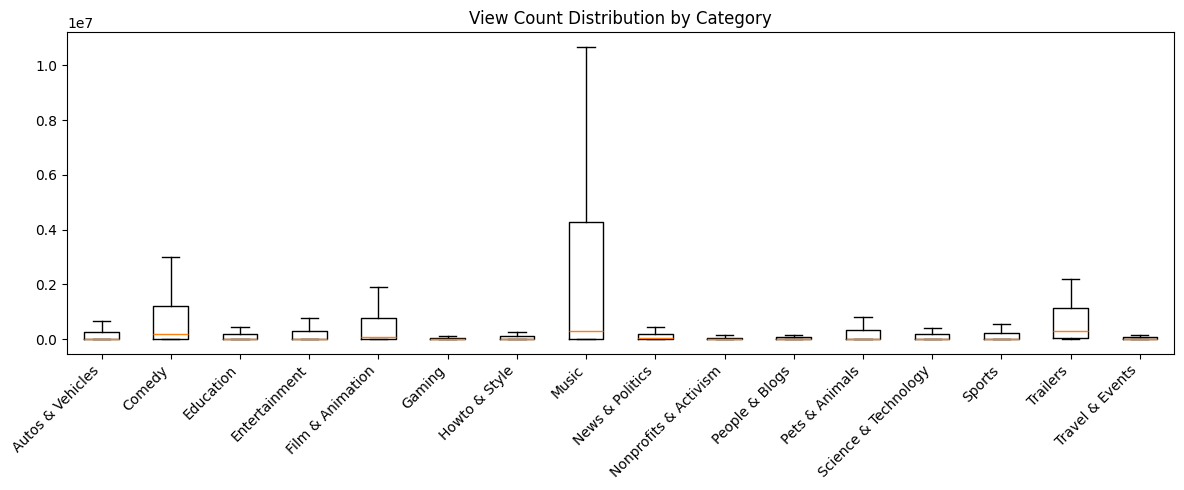

In [40]:
vc = clean_df.groupby("category_title")["view_count"].apply(list)

plt.figure(figsize=(12,5))
plt.boxplot(vc.tolist(), labels=vc.index, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("View Count Distribution by Category")
plt.tight_layout()
plt.show()



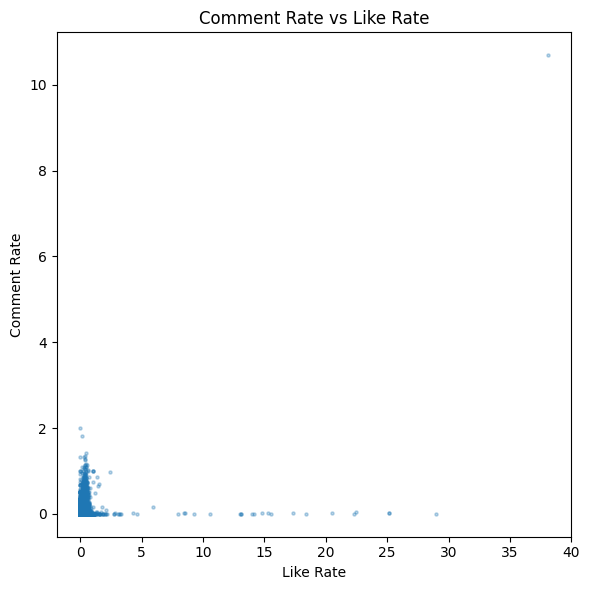

In [42]:
df = video_df.dropna(subset=["like_rate","comment_rate"])
plt.figure(figsize=(6,6))
plt.scatter(df["like_rate"], df["comment_rate"], s=5, alpha=0.3)
plt.xlabel("Like Rate")
plt.ylabel("Comment Rate")
plt.title("Comment Rate vs Like Rate")
plt.tight_layout()
plt.show()


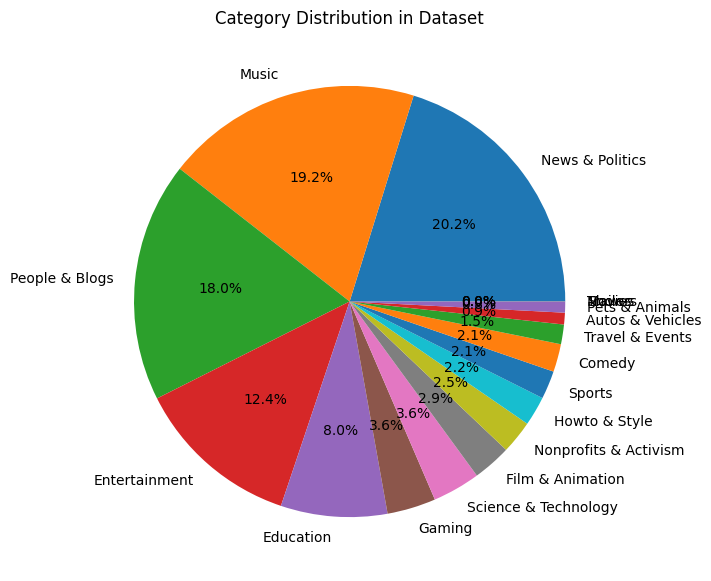

In [37]:
cat_counts = video_df["category_title"].value_counts()
plt.figure(figsize=(7,7))
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%')
plt.title("Category Distribution in Dataset")
plt.show()
